In [ ]:
!pip install transformers torchaudio librosa pandas tqdm shap
!pip install --upgrade scikit-learn




KeyboardInterrupt: 

In [ ]:
import os, torch, librosa, numpy as np, pandas as pd
from tqdm import tqdm
from transformers import AutoFeatureExtractor, WavLMModel
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, recall_score, precision_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Deep Embedded Model**

In [ ]:
meta_path = "/content/drive/MyDrive/Major Project/PD_audio/Demographics_age_sex.xlsx"
df = pd.read_excel(meta_path, sheet_name="Parselmouth")[['Sample ID','Label']]
df = df.rename(columns={'Sample ID':'filename','Label':'label'})
df['label'] = df['label'].map({'HC':0,'PwPD':1})
df.dropna(inplace=True)
print(df.head(), df['label'].value_counts())


                                       filename  label
0  AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5      0
1  AH_114S_A89F3548-0B61-4770-B800-2E26AB3908B6      0
2  AH_121A_BD5BA248-E807-4CB9-8B53-47E7FFE5F8E2      0
3  AH_123G_559F0706-2238-447C-BA39-DB5933BA619D      0
4  AH_195B_39DA6A45-F4CC-492A-80D4-FB79049ACC22      0 label
0    41
1    40
Name: count, dtype: int64


In [ ]:
base_path = "/content/drive/MyDrive/Major Project/PD_audio"

data = []

# Healthy controls
hc_folder = os.path.join(base_path, "HC_AH", "HC_AH")
for file in os.listdir(hc_folder):
    if file.endswith(".wav"):
        data.append({
            "filepath": os.path.join(hc_folder, file),
            "label": 0,
            "group": "HC"
        })

# Parkinson’s patients
pd_folder = os.path.join(base_path, "PD_AH", "PD_AH")
for file in os.listdir(pd_folder):
    if file.endswith(".wav"):
        data.append({
            "filepath": os.path.join(pd_folder, file),
            "label": 1,
            "group": "PD"
        })

df = pd.DataFrame(data)
print("✅ Total files:", len(df))
print(df.groupby('group').size())
df.head()

✅ Total files: 81
group
HC    41
PD    40
dtype: int64


,filepath,label,group
0,/content/drive/MyDrive/Major Project/PD_audio/...,0,HC
1,/content/drive/MyDrive/Major Project/PD_audio/...,0,HC
2,/content/drive/MyDrive/Major Project/PD_audio/...,0,HC
3,/content/drive/MyDrive/Major Project/PD_audio/...,0,HC
4,/content/drive/MyDrive/Major Project/PD_audio/...,0,HC


In [ ]:
# ⚙️ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Load pretrained model (no tokenizer needed)
extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")
model = WavLMModel.from_pretrained("microsoft/wavlm-base-plus").to(device)

# 🗂️ Folder setup
base_path = "/content/drive/MyDrive/Major Project/PD_audio"
hc_folder = os.path.join(base_path, "HC_AH", "HC_AH")
pd_folder = os.path.join(base_path, "PD_AH", "PD_AH")

data = []
for file in os.listdir(hc_folder):
    if file.endswith(".wav"):
        data.append({"filepath": os.path.join(hc_folder, file), "label": 0, "group": "HC"})
for file in os.listdir(pd_folder):
    if file.endswith(".wav"):
        data.append({"filepath": os.path.join(pd_folder, file), "label": 1, "group": "PD"})

df = pd.DataFrame(data)
print("✅ Total files:", len(df))
print(df.groupby("group").size())

# 🎧 Embedding extraction function
def extract_embedding(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    inputs = extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(inputs.input_values.to(device))
        emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return emb.squeeze()

# 📦 Save locations
save_emb_path = "/content/drive/MyDrive/Major Project/PD_audio/wavlm_embeddings.npy"
save_lbl_path = "/content/drive/MyDrive/Major Project/PD_audio/wavlm_labels.npy"

# 🚀 Run extraction
if os.path.exists(save_emb_path) and os.path.exists(save_lbl_path):
    print("✅ Found existing embeddings, loading...")
    X = np.load(save_emb_path)
    y = np.load(save_lbl_path)
else:
    print("🔄 Extracting embeddings using WavLM...")

    embeddings, labels = [], []
    for path, lbl in tqdm(zip(df['filepath'], df['label']), total=len(df)):
        try:
            emb = extract_embedding(path)
            embeddings.append(emb)
            labels.append(lbl)
        except Exception as e:
            print("⚠️ Skipped:", path, e)

    X = np.vstack(embeddings)
    y = np.array(labels)
    print("✅ Embeddings extracted:", X.shape)

    # 💾 Save for reuse
    np.save(save_emb_path, X)
    np.save(save_lbl_path, y)
    print("💾 Saved embeddings to Drive as wavlm_embeddings.npy")


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

✅ Total files: 81
group
HC    41
PD    40
dtype: int64
✅ Found existing embeddings, loading...


In [ ]:
# 📂 Load saved WavLM embeddings
X = np.load("/content/drive/MyDrive/Major Project/PD_audio/wavlm_embeddings.npy")
y = np.load("/content/drive/MyDrive/Major Project/PD_audio/wavlm_labels.npy")

print("✅ Loaded:", X.shape, "embeddings")

# 🧩 Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("Train class balance:", np.bincount(y_train))
print("Val class balance:", np.bincount(y_val))
print("Test class balance:", np.bincount(y_test))

# ⚙️ Standardize features (fit only on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# ⚙️ Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


✅ Loaded: (81, 768) embeddings
Train: (56, 768), Val: (12, 768), Test: (13, 768)
Train class balance: [28 28]
Val class balance: [6 6]
Test class balance: [7 6]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42, use_label_encoder=False, eval_metric='logloss'
    )
}
results = []
roc_data = {}

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import time

In [ ]:
for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    start = time.time()
    model.fit(X_train_scaled, y_train)
    end = time.time()
    print(f"⏱️ Training time: {end - start:.2f} sec")

    y_pred = model.predict(X_test_scaled)

    # Handle predict_proba for AUC and ROC
    try:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_data[name] = (fpr, tpr, auc_score)
    except Exception:
        y_proba = None
        auc_score = np.nan
        print("⚠️ Skipped AUC (no predict_proba support)")

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print results
    print(f"\n{name} Results:")
    print(f"✅ Accuracy:  {acc:.3f}")
    print(f"✅ Precision: {prec:.3f}")
    print(f"✅ Recall:    {rec:.3f}")
    print(f"✅ F1-score:  {f1:.3f}")
    if not np.isnan(auc_score):
        print(f"✅ ROC-AUC:   {auc_score:.3f}")
    print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))

    results.append([name, acc, prec, rec, f1, auc_score, end - start])




🚀 Training Random Forest...
⏱️ Training time: 1.95 sec

Random Forest Results:
✅ Accuracy:  0.538
✅ Precision: 0.500
✅ Recall:    0.833
✅ F1-score:  0.625
✅ ROC-AUC:   0.476

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.50      0.83      0.62         6

    accuracy                           0.54        13
   macro avg       0.58      0.56      0.51        13
weighted avg       0.59      0.54      0.50        13


🚀 Training SVM (RBF)...
⏱️ Training time: 0.01 sec

SVM (RBF) Results:
✅ Accuracy:  0.462
✅ Precision: 0.444
✅ Recall:    0.667
✅ F1-score:  0.533
✅ ROC-AUC:   0.405

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.29      0.36         7
           1       0.44      0.67      0.53         6

    accuracy                           0.46        13
   macro avg       0.47      0.48      0.45        13
weigh

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:00:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


⏱️ Training time: 1.31 sec

XGBoost Results:
✅ Accuracy:  0.615
✅ Precision: 0.571
✅ Recall:    0.667
✅ F1-score:  0.615
✅ ROC-AUC:   0.690

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.57      0.67      0.62         6

    accuracy                           0.62        13
   macro avg       0.62      0.62      0.62        13
weighted avg       0.62      0.62      0.62        13



In [ ]:
# Summary table
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC", "Train Time (s)"]
)
display(results_df.round(3))

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,Train Time (s)
0,Random Forest,0.538,0.500,0.833,0.625,0.476,1.945
1,SVM (RBF),0.462,0.444,0.667,0.533,0.405,0.009
2,XGBoost,0.615,0.571,0.667,0.615,0.690,1.306


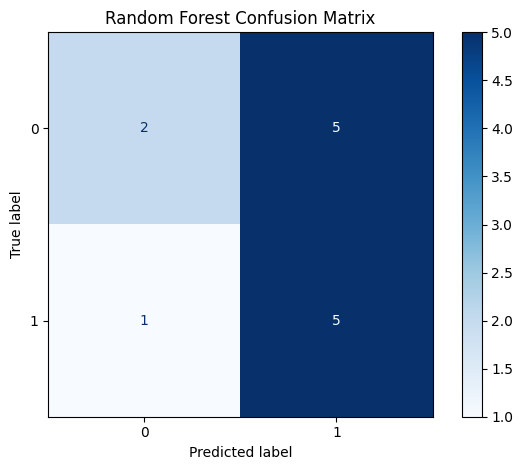

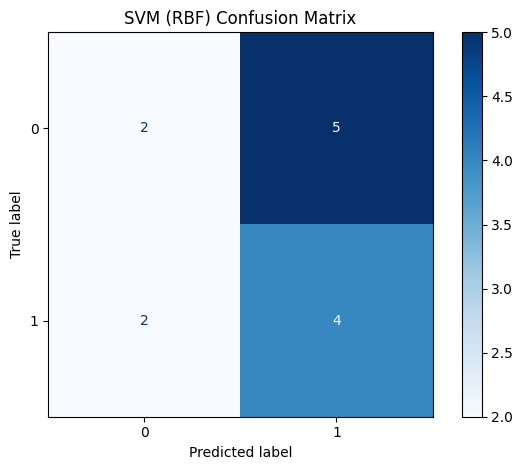

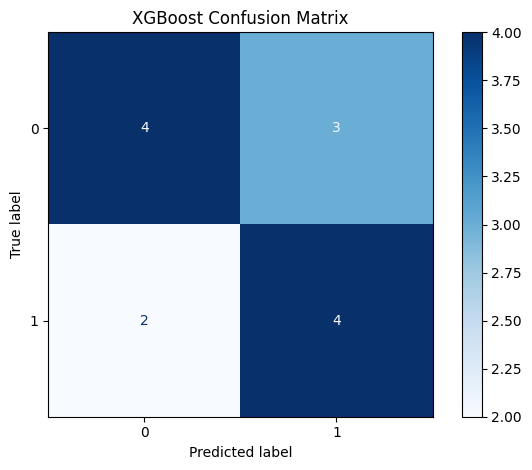

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{name} Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [ ]:
X_sample = X_test_scaled
y_sample = y_test

print("✅ SHAP sample size:", X_sample.shape)

✅ SHAP sample size: (13, 768)


In [ ]:
# --- Train Random Forest on scaled embeddings ---
rf_model = models["Random Forest"]
rf_model.fit(X_train_scaled, y_train)

# --- Generate feature names dynamically ---
n_features = X_train_scaled.shape[1]
feature_names = [f"Embedding_{i+1}" for i in range(n_features)]

# --- SHAP Explainer ---
explainer_rf = shap.TreeExplainer(rf_model)
# Use a small subset of X_test_scaled to save memory if needed
X_shap = X_test_scaled[:500] if X_test_scaled.shape[0] > 500 else X_test_scaled
shap_values_rf = explainer_rf.shap_values(X_shap)

# --- Handle binary classification safely ---
if isinstance(shap_values_rf, list) and len(shap_values_rf) == 2:
    shap_values_used = shap_values_rf[1]  # positive class
else:
    shap_values_used = shap_values_rf

# --- Compute mean absolute SHAP values ---
mean_shap = np.abs(shap_values_used).mean(axis=0).flatten()

# --- Safety check ---
if len(feature_names) != len(mean_shap):
    print(f"⚠️ Mismatch: {len(feature_names)} names vs {len(mean_shap)} SHAP features")
    feature_names = [f"Feature_{i+1}" for i in range(len(mean_shap))]

# --- Top 5 features ---
top5_idx = np.argsort(mean_shap)[-5:][::-1]
top5_features = [feature_names[i] for i in top5_idx]
top5_values = mean_shap[top5_idx].flatten()

# --- Display ---
top5_df = pd.DataFrame({
    "Rank": range(1, len(top5_features)+1),
    "Feature": top5_features,
    "Mean |SHAP Value|": np.round(top5_values, 4)
})

print("🌟 Top 5 Influential Embedding Features (Random Forest):")
display(top5_df)

⚠️ Mismatch: 768 names vs 1536 SHAP features
🌟 Top 5 Influential Embedding Features (Random Forest):


,Rank,Feature,Mean |SHAP Value|
0,1,Feature_499,0.0117
1,2,Feature_500,0.0117
2,3,Feature_1495,0.0103
3,4,Feature_1496,0.0103
4,5,Feature_1317,0.0065


<Figure size 1000x600 with 0 Axes>

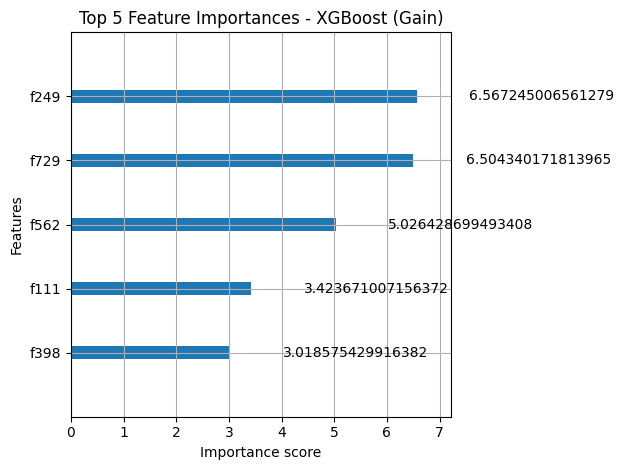

   Feature      Gain
36    f249  6.567245
75    f729  6.504340
58    f562  5.026429
18    f111  3.423671
50    f398  3.018575


In [ ]:
xgb_model = models['XGBoost']
plt.figure(figsize=(10,6))
plot_importance(xgb_model, importance_type='gain', max_num_features=5)
plt.title("Top 5 Feature Importances - XGBoost (Gain)")
plt.tight_layout()
plt.show()

# To get data as DataFrame
xgb_importances = xgb_model.get_booster().get_score(importance_type='gain')
xgb_importance_df = pd.DataFrame(list(xgb_importances.items()), columns=["Feature", "Gain"]).sort_values(by="Gain", ascending=False)
print(xgb_importance_df.head(5))


In [ ]:
pca = PCA(n_components=0.95, random_state=42)   # keeps 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("✅ PCA reduced shape:", X_train_pca.shape)

pca_models = {
    "Random Forest (PCA)": RandomForestClassifier(n_estimators=300, random_state=42),
    "SVM (RBF, PCA)": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
    "XGBoost (PCA)": XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42,
        use_label_encoder=False, eval_metric='logloss'
    )
}

pca_results = []
roc_data_pca = {}

✅ PCA reduced shape: (56, 27)


In [ ]:
for name, model in pca_models.items():
    print(f"\n🚀 Training {name}...")
    start = time.time()
    model.fit(X_train_pca, y_train)
    end = time.time()

    y_pred = model.predict(X_test_pca)

    try:
        y_proba = model.predict_proba(X_test_pca)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_data_pca[name] = (fpr, tpr, auc_score)
    except Exception:
        y_proba = None
        auc_score = np.nan

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name} Results:")
    print(f"✅ Accuracy:  {acc:.3f}")
    print(f"✅ Precision: {prec:.3f}")
    print(f"✅ Recall:    {rec:.3f}")
    print(f"✅ F1-score:  {f1:.3f}")
    if not np.isnan(auc_score):
        print(f"✅ ROC-AUC:   {auc_score:.3f}")
    print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
    print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    pca_results.append([name, acc, prec, rec, f1, auc_score, end - start])


🚀 Training Random Forest (PCA)...

Random Forest (PCA) Results:
✅ Accuracy:  0.462
✅ Precision: 0.455
✅ Recall:    0.833
✅ F1-score:  0.588
✅ ROC-AUC:   0.393

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.45      0.83      0.59         6

    accuracy                           0.46        13
   macro avg       0.48      0.49      0.41        13
weighted avg       0.48      0.46      0.39        13

🧩 Confusion Matrix:
 [[1 6]
 [1 5]]

🚀 Training SVM (RBF, PCA)...

SVM (RBF, PCA) Results:
✅ Accuracy:  0.538
✅ Precision: 0.500
✅ Recall:    0.833
✅ F1-score:  0.625
✅ ROC-AUC:   0.429

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.50      0.83      0.62         6

    accuracy                           0.54        13
   macro avg       0.58      0.56      0.51        13
w

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:00:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (PCA) Results:
✅ Accuracy:  0.538
✅ Precision: 0.500
✅ Recall:    0.833
✅ F1-score:  0.625
✅ ROC-AUC:   0.500

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.50      0.83      0.62         6

    accuracy                           0.54        13
   macro avg       0.58      0.56      0.51        13
weighted avg       0.59      0.54      0.50        13

🧩 Confusion Matrix:
 [[2 5]
 [1 5]]


In [ ]:
pca_results_df = pd.DataFrame(
    pca_results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC", "Train Time (s)"]
)
display(pca_results_df.round(3))

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,Train Time (s)
0,Random Forest (PCA),0.462,0.455,0.833,0.588,0.393,1.099
1,"SVM (RBF, PCA)",0.538,0.500,0.833,0.625,0.429,0.003
2,XGBoost (PCA),0.538,0.500,0.833,0.625,0.500,0.165


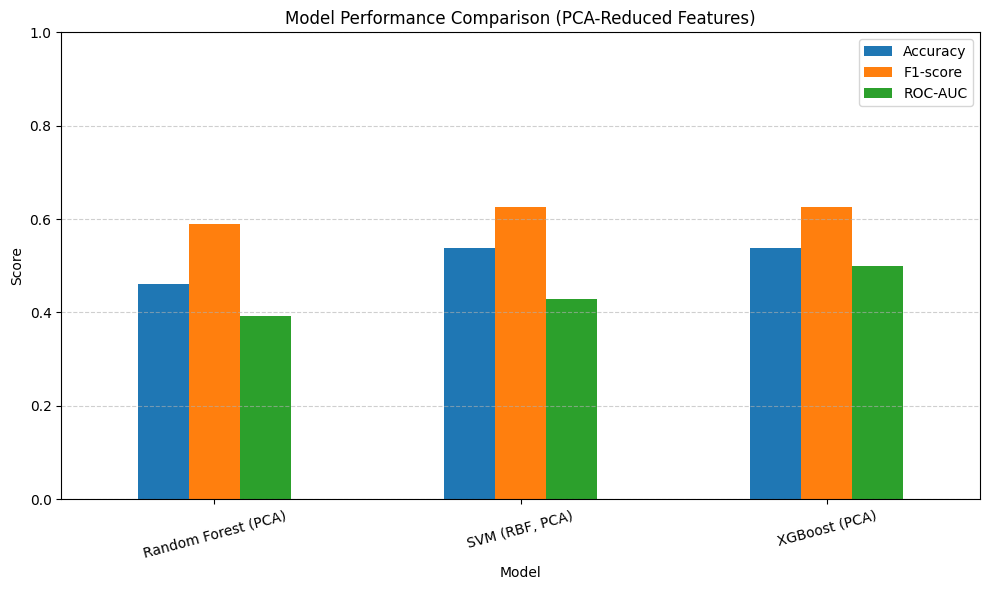

In [ ]:
pca_results_df.set_index("Model")[["Accuracy", "F1-score", "ROC-AUC"]].plot(
    kind="bar", figsize=(10, 6), rot=15
)
plt.title("Model Performance Comparison (PCA-Reduced Features)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


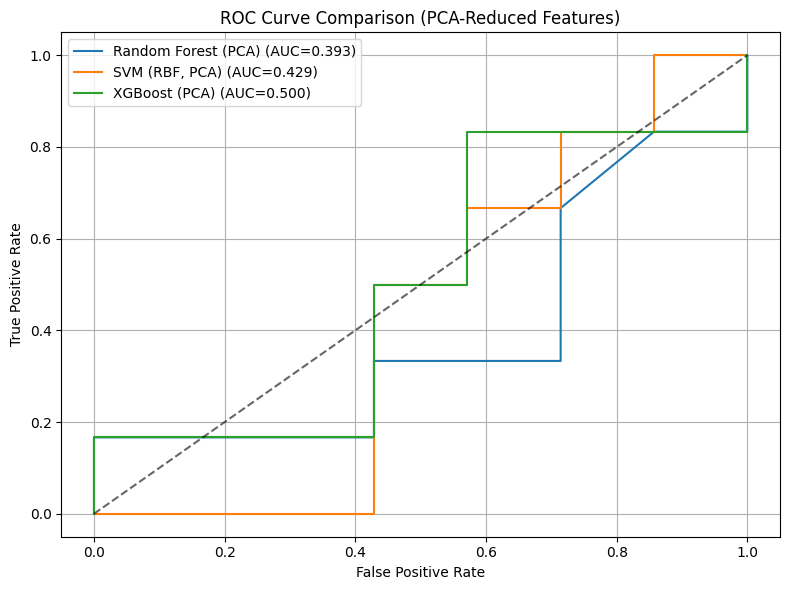

In [ ]:
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_score) in roc_data_pca.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (PCA-Reduced Features)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Classical model(Handcrafted Features)**

In [ ]:
excel_path = "/content/drive/MyDrive/Major Project/PD_audio/Demographics_age_sex.xlsx"

xls = pd.ExcelFile(excel_path)
print("🧾 Sheets found:", xls.sheet_names)

for sheet in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    print(f"\n📄 {sheet} → columns:\n{list(df.columns)}")


🧾 Sheets found: ['Parselmouth', 'LPC_means', 'LAR_means', 'Cep_means', 'MFCC_means', 'LPC_vars', 'LAR_vars', 'Cep_vars', 'MFCC_vars']

📄 Parselmouth → columns:
['Sample ID', 'Label', 'Age', 'Sex']

📄 LPC_means → columns:
['Sample', 'LPC1', 'LPC2', 'LPC3', 'LPC4', 'LPC5', 'LPC6', 'LPC7', 'LPC8', 'LPC9', 'LPC10', 'Label']

📄 LAR_means → columns:
['Sample', 'LAR1', 'LAR2', 'LAR3', 'LAR4', 'LAR5', 'LAR6', 'LAR7', 'LAR8', 'LAR9', 'LAR10', 'Label']

📄 Cep_means → columns:
['Sample', 'Cep1', 'Cep2', 'Cep3', 'Cep4', 'Cep5', 'Cep6', 'Cep7', 'Cep8', 'Cep9', 'Cep10', 'Label']

📄 MFCC_means → columns:
['Sample', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7', 'MFCC8', 'MFCC9', 'MFCC10', 'Label']

📄 LPC_vars → columns:
['Sample', 'LPC1', 'LPC2', 'LPC3', 'LPC4', 'LPC5', 'LPC6', 'LPC7', 'LPC8', 'LPC9', 'LPC10', 'Label']

📄 LAR_vars → columns:
['Sample', 'LAR1', 'LAR2', 'LAR3', 'LAR4', 'LAR5', 'LAR6', 'LAR7', 'LAR8', 'LAR9', 'LAR10', 'Label']

📄 Cep_vars → columns:
['Sample', 'Cep1', 'C

In [ ]:
# -------------------------------
# 1️⃣ Load handcrafted features
# -------------------------------
# Define all feature sheet names
sheet_names = ['LPC_means', 'LAR_means', 'Cep_means', 'MFCC_means',
               'LPC_vars', 'LAR_vars', 'Cep_vars', 'MFCC_vars']

df_features = None

for sheet in sheet_names:
    temp = pd.read_excel(excel_path, sheet_name=sheet)
    print(f"{sheet}: {temp.shape}")

    # Standardize key column name
    if 'Sample' in temp.columns:
        temp.rename(columns={'Sample': 'Sample ID'}, inplace=True)

    # Add sheet name as suffix for all feature columns (except key)
    temp = temp.rename(columns={col: f"{col}_{sheet}" for col in temp.columns if col != 'Sample ID'})

    # Merge progressively
    if df_features is None:
        df_features = temp
    else:
        df_features = df_features.merge(temp, on='Sample ID', how='outer')

print("\n✅ Combined features shape:", df_features.shape)

# Load metadata (labels + demographics)
df_meta = pd.read_excel(excel_path, sheet_name="Parselmouth")[['Sample ID', 'Label', 'Age', 'Sex']]

# Merge features + labels
df = df_features.merge(df_meta, on='Sample ID', how='left')
df = df.dropna(subset=['Label'])  # keep only labeled rows

print("✅ Final dataset shape:", df.shape)
df.head()

LPC_means: (81, 12)
LAR_means: (81, 12)
Cep_means: (81, 12)
MFCC_means: (81, 12)
LPC_vars: (81, 12)
LAR_vars: (81, 12)
Cep_vars: (81, 12)
MFCC_vars: (81, 12)

✅ Combined features shape: (81, 89)
✅ Final dataset shape: (81, 92)


,Sample ID,LPC1_LPC_means,LPC2_LPC_means,LPC3_LPC_means,LPC4_LPC_means,LPC5_LPC_means,LPC6_LPC_means,LPC7_LPC_means,LPC8_LPC_means,LPC9_LPC_means,...,MFCC5_MFCC_vars,MFCC6_MFCC_vars,MFCC7_MFCC_vars,MFCC8_MFCC_vars,MFCC9_MFCC_vars,MFCC10_MFCC_vars,Label_MFCC_vars,Label,Age,Sex
0,AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5,1.569877,-0.983969,-0.091904,0.041568,0.191788,-0.288774,0.322170,-0.598547,0.407556,...,0.025198,0.075028,0.026978,0.022016,0.049959,0.016487,HC,HC,69.0,M
1,AH_114S_A89F3548-0B61-4770-B800-2E26AB3908B6,1.941508,-1.604020,0.596933,-0.203145,0.049751,0.149339,-0.181571,-0.076214,0.181712,...,0.076834,0.177133,0.106460,0.058875,0.070278,0.057396,HC,HC,43.0,M
2,AH_121A_BD5BA248-E807-4CB9-8B53-47E7FFE5F8E2,1.939210,-1.400189,0.267341,-0.117478,0.393466,-0.146857,-0.267388,0.218443,0.052065,...,0.032045,0.029428,0.045059,0.037183,0.020112,0.016252,HC,HC,18.0,F
3,AH_123G_559F0706-2238-447C-BA39-DB5933BA619D,1.742062,-1.111498,0.209142,-0.208665,0.172042,0.230845,-0.125670,-0.521256,0.695029,...,0.023448,0.048831,0.026585,0.024423,0.011855,0.016314,HC,HC,28.0,M
4,AH_195B_39DA6A45-F4CC-492A-80D4-FB79049ACC22,1.370398,-0.725562,0.058470,-0.669424,0.762271,-0.077152,-0.350492,-0.027547,0.154888,...,0.032242,0.031627,0.053048,0.027289,0.119403,0.046914,HC,HC,68.0,M


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 92 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sample ID          81 non-null     object 
 1   LPC1_LPC_means     81 non-null     float64
 2   LPC2_LPC_means     81 non-null     float64
 3   LPC3_LPC_means     81 non-null     float64
 4   LPC4_LPC_means     81 non-null     float64
 5   LPC5_LPC_means     81 non-null     float64
 6   LPC6_LPC_means     81 non-null     float64
 7   LPC7_LPC_means     81 non-null     float64
 8   LPC8_LPC_means     81 non-null     float64
 9   LPC9_LPC_means     81 non-null     float64
 10  LPC10_LPC_means    81 non-null     float64
 11  Label_LPC_means    81 non-null     object 
 12  LAR1_LAR_means     81 non-null     float64
 13  LAR2_LAR_means     81 non-null     float64
 14  LAR3_LAR_means     81 non-null     float64
 15  LAR4_LAR_means     81 non-null     float64
 16  LAR5_LAR_means     81 non-nu

In [ ]:
df = df.drop(columns=[col for col in df.columns if "Label_" in col], errors='ignore')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sample ID          81 non-null     object 
 1   LPC1_LPC_means     81 non-null     float64
 2   LPC2_LPC_means     81 non-null     float64
 3   LPC3_LPC_means     81 non-null     float64
 4   LPC4_LPC_means     81 non-null     float64
 5   LPC5_LPC_means     81 non-null     float64
 6   LPC6_LPC_means     81 non-null     float64
 7   LPC7_LPC_means     81 non-null     float64
 8   LPC8_LPC_means     81 non-null     float64
 9   LPC9_LPC_means     81 non-null     float64
 10  LPC10_LPC_means    81 non-null     float64
 11  LAR1_LAR_means     81 non-null     float64
 12  LAR2_LAR_means     81 non-null     float64
 13  LAR3_LAR_means     81 non-null     float64
 14  LAR4_LAR_means     81 non-null     float64
 15  LAR5_LAR_means     81 non-null     float64
 16  LAR6_LAR_means     81 non-nu

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode 'Sex' column to numerical values
le_sex = LabelEncoder()
df['Sex'] = le_sex.fit_transform(df['Sex'])

# Map 'Label' to numerical 'y'
df['y'] = df['Label'].map({'PwPD': 1, 'HC': 0})
print("Label counts:\n", df['y'].value_counts())
print("Sex encoded:\n", df['Sex'].value_counts())

Label counts:
 y
0    41
1    40
Name: count, dtype: int64
Sex encoded:
 Sex
0    44
1    37
Name: count, dtype: int64


In [ ]:
df.describe()

,LPC1_LPC_means,LPC2_LPC_means,LPC3_LPC_means,LPC4_LPC_means,LPC5_LPC_means,LPC6_LPC_means,LPC7_LPC_means,LPC8_LPC_means,LPC9_LPC_means,LPC10_LPC_means,...,MFCC4_MFCC_vars,MFCC5_MFCC_vars,MFCC6_MFCC_vars,MFCC7_MFCC_vars,MFCC8_MFCC_vars,MFCC9_MFCC_vars,MFCC10_MFCC_vars,Age,Sex,y
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,...,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,1.594083,-0.999559,0.105330,-0.248627,0.436917,-0.213832,-0.037633,-0.085926,0.139710,-0.066076,...,0.086700,0.085464,0.082428,0.077640,0.070417,0.074238,0.068870,57.264198,0.456790,0.493827
std,0.256121,0.455513,0.440579,0.379721,0.321555,0.311906,0.238725,0.260511,0.208734,0.090962,...,0.097089,0.081455,0.065749,0.058848,0.063464,0.063071,0.048299,15.371786,0.501233,0.503077
min,0.923475,-1.955843,-0.957053,-1.314744,-0.252382,-0.938685,-0.497032,-0.723733,-0.389519,-0.317868,...,0.007098,0.010019,0.006807,0.009808,0.006674,0.010808,0.004523,18.000000,0.000000,0.000000
25%,1.428698,-1.276864,-0.160625,-0.512572,0.189548,-0.418575,-0.228364,-0.266675,0.002119,-0.114293,...,0.038427,0.032242,0.035516,0.033590,0.028349,0.028739,0.036144,44.000000,0.000000,0.000000
50%,1.620231,-1.002650,0.063049,-0.208665,0.446606,-0.187674,-0.068839,-0.076214,0.128621,-0.074457,...,0.056222,0.063872,0.065067,0.059496,0.056528,0.055569,0.050998,58.140000,0.000000,0.000000
75%,1.790834,-0.746939,0.309396,0.041568,0.665490,-0.009242,0.132962,0.104372,0.303716,-0.010398,...,0.101715,0.106148,0.112672,0.101623,0.089988,0.101336,0.092603,69.450000,1.000000,1.000000
max,2.044157,0.494960,1.519694,0.467297,1.147827,0.420737,0.623928,0.384695,0.695029,0.214964,...,0.683617,0.557014,0.303602,0.285948,0.368150,0.359709,0.206196,85.310000,1.000000,1.000000


In [ ]:
exclude_cols = ['Sample ID', 'Label', 'Age', 'y']
X_handcrafted = df.drop(columns=exclude_cols)  # Only numeric features left
y_handcrafted = df['y'].values

In [ ]:
Xh_train, Xh_temp, yh_train, yh_temp = train_test_split(
    X_handcrafted, y_handcrafted,
    test_size=0.3,
    stratify=y_handcrafted,
    random_state=42
)

# -----------------------------
# 3️⃣ Split temp into validation (15%) and test (15%)
# -----------------------------
Xh_val, Xh_test, yh_val, yh_test = train_test_split(
    Xh_temp, yh_temp,
    test_size=0.5,  # split temp equally for val/test
    stratify=yh_temp,
    random_state=42
)

# -----------------------------
# 4️⃣ Print shapes and class balance
# -----------------------------
print(f"Train: {Xh_train.shape}, Val: {Xh_val.shape}, Test: {Xh_test.shape}")
print("Train class balance:", np.bincount(yh_train))
print("Val class balance:", np.bincount(yh_val))
print("Test class balance:", np.bincount(yh_test))

Train: (56, 81), Val: (12, 81), Test: (13, 81)
Train class balance: [28 28]
Val class balance: [6 6]
Test class balance: [7 6]


In [ ]:
scaler = StandardScaler()
Xh_train_scaled = scaler.fit_transform(Xh_train)
Xh_val_scaled = scaler.transform(Xh_val)
Xh_test_scaled = scaler.transform(Xh_test)

print("✅ Handcrafted feature scaling complete.")

✅ Handcrafted feature scaling complete.


In [ ]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=5, min_samples_leaf=3, random_state=42
    ),
    'SVC': SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=4, reg_alpha=0.5, reg_lambda=1.0,
        use_label_encoder=False, eval_metric='logloss', random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        penalty='l2', C=1.0, max_iter=1000, solver='liblinear', random_state=42
    )
}


Random Forest Validation Results:
              precision    recall  f1-score   support

           0     0.6250    0.8333    0.7143         6
           1     0.7500    0.5000    0.6000         6

    accuracy                         0.6667        12
   macro avg     0.6875    0.6667    0.6571        12
weighted avg     0.6875    0.6667    0.6571        12


SVC Validation Results:
              precision    recall  f1-score   support

           0     0.6250    0.8333    0.7143         6
           1     0.7500    0.5000    0.6000         6

    accuracy                         0.6667        12
   macro avg     0.6875    0.6667    0.6571        12
weighted avg     0.6875    0.6667    0.6571        12


XGBoost Validation Results:
              precision    recall  f1-score   support

           0     0.5714    0.6667    0.6154         6
           1     0.6000    0.5000    0.5455         6

    accuracy                         0.5833        12
   macro avg     0.5857    0.5833    0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:02:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Train Accuracy,Val Accuracy,Train F1,Val F1,Train Precision,Val Precision,Train Recall,Val Recall
Random Forest,0.9821,0.6667,0.9821,0.6571,0.9828,0.6875,0.9821,0.6667
SVC,0.9107,0.6667,0.9100,0.6571,0.9242,0.6875,0.9107,0.6667
XGBoost,1.0000,0.5833,1.0000,0.5804,1.0000,0.5857,1.0000,0.5833
Logistic Regression,0.9821,0.5000,0.9821,0.4857,0.9828,0.5000,0.9821,0.5000


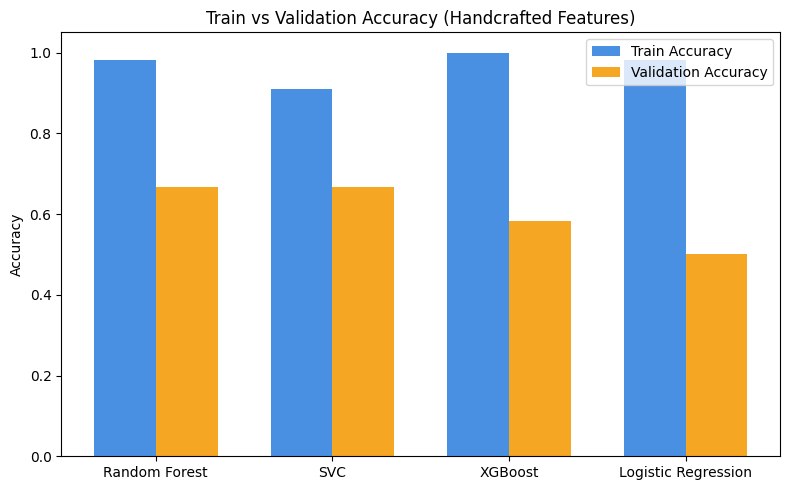

In [ ]:
results = {}
for name, model in models.items():
    # Train
    model.fit(Xh_train_scaled, yh_train)

    # Predictions
    y_train_pred = model.predict(Xh_train_scaled)
    y_val_pred = model.predict(Xh_val_scaled)

    # Metrics
    train_acc = accuracy_score(yh_train, y_train_pred)
    val_acc = accuracy_score(yh_val, y_val_pred)

    train_f1 = f1_score(yh_train, y_train_pred, average='weighted')
    val_f1 = f1_score(yh_val, y_val_pred, average='weighted')

    train_precision = precision_score(yh_train, y_train_pred, average='weighted')
    val_precision = precision_score(yh_val, y_val_pred, average='weighted')

    train_recall = recall_score(yh_train, y_train_pred, average='weighted')
    val_recall = recall_score(yh_val, y_val_pred, average='weighted')

    results[name] = {
        'Train Accuracy': train_acc,
        'Val Accuracy': val_acc,
        'Train F1': train_f1,
        'Val F1': val_f1,
        'Train Precision': train_precision,
        'Val Precision': val_precision,
        'Train Recall': train_recall,
        'Val Recall': val_recall
    }

    print(f"\n{name} Validation Results:")
    print(classification_report(yh_val, y_val_pred, digits=4))

# -----------------------------
# 4️⃣ Summary table
# -----------------------------
results_df = pd.DataFrame(results).T
display(results_df.round(4))

# -----------------------------
# 5️⃣ Plot Accuracy: Train vs Validation
# -----------------------------
train_accs = [results[name]['Train Accuracy'] for name in models]
val_accs = [results[name]['Val Accuracy'] for name in models]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, train_accs, width, label='Train Accuracy', color='#4A90E2')
plt.bar(x + width/2, val_accs, width, label='Validation Accuracy', color='#F5A623')
plt.xticks(x, models.keys())
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy (Handcrafted Features)")
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

Random Forest shap_values.values.shape: (12, 81, 2)


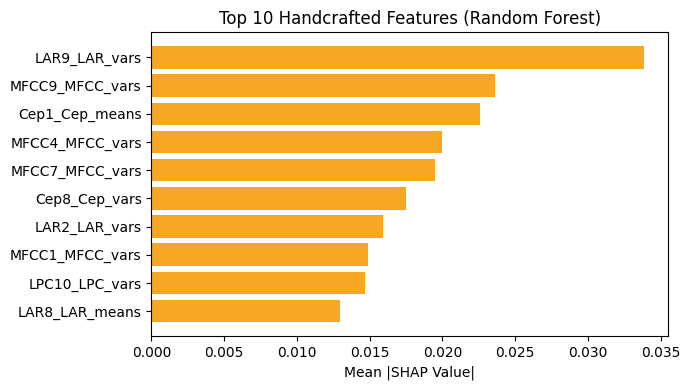

,Feature,Mean |SHAP Value|
58,LAR9_LAR_vars,0.033827
78,MFCC9_MFCC_vars,0.023622
20,Cep1_Cep_means,0.022566
73,MFCC4_MFCC_vars,0.019984
76,MFCC7_MFCC_vars,0.019525
67,Cep8_Cep_vars,0.017493
51,LAR2_LAR_vars,0.015912
70,MFCC1_MFCC_vars,0.014893
49,LPC10_LPC_vars,0.014680
17,LAR8_LAR_means,0.012965


In [ ]:
model_1 = models['Random Forest']
name = 'Random Forest'

# SHAP explainer
explainer = shap.TreeExplainer(model_1)
shap_values = explainer(Xh_val_scaled)

print(name, "shap_values.values.shape:", shap_values.values.shape)  # (n_samples, n_features, n_classes)

# Take absolute values and select class 1 (PD)
abs_shap_class1 = np.abs(shap_values.values[:, :, 1])  # shape: (n_samples, n_features)

# Compute mean across samples
mean_shap = abs_shap_class1.mean(axis=0)  # shape: (n_features,)

# Create DataFrame
shap_df = pd.DataFrame({
    'Feature': X_handcrafted.columns,
    'Mean |SHAP Value|': mean_shap
}).sort_values(by='Mean |SHAP Value|', ascending=False)

# Plot top 10 features
top10 = shap_df.head(10)
plt.figure(figsize=(7,4))
plt.barh(top10['Feature'], top10['Mean |SHAP Value|'], color='#F5A623')
plt.xlabel("Mean |SHAP Value|")
plt.title(f"Top 10 Handcrafted Features ({name})")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Optional: display top 10 features
display(top10)

In [ ]:
# Check shapes
print("X_handcrafted columns:", X_handcrafted.shape[1])
print("SHAP values shape:", shap_values.shape)


X_handcrafted columns: 81
SHAP values shape: (12, 81, 2)


**Hybrid Model**

In [ ]:
# Identify categorical columns (e.g., Sex, Age if categorical)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns found:", categorical_cols)

# Encode them
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Now rebuild the hybrid features after encoding
X_handcrafted = df.drop(columns=['Sample ID', 'Label']).values
X_hybrid = np.hstack((X_handcrafted, X))
y = df['Label'].values



Categorical columns found: ['Sample ID', 'Label']


In [ ]:
# -------------------------------
# 🔹 Load WavLM embeddings
# -------------------------------
X_wavlm = np.load("/content/drive/MyDrive/Major Project/PD_audio/wavlm_embeddings.npy")
y_wavlm = np.load("/content/drive/MyDrive/Major Project/PD_audio/wavlm_labels.npy")

# -------------------------------
# 🔹 Handcrafted features from the dataframe
# -------------------------------
# Select numeric columns only
feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Drop columns that are not actual features
exclude_cols = ['y', 'Label', 'Age', 'Sample ID']
handcrafted_feature_cols = [f for f in feature_cols if f not in exclude_cols]

# Extract handcrafted features
X_handcrafted = df[handcrafted_feature_cols].to_numpy()
y_handcrafted = df['y'].to_numpy()  # integer labels

# -------------------------------
# 🔹 Combine handcrafted + WavLM embeddings
# -------------------------------
X_hybrid = np.concatenate([X_wavlm, X_handcrafted], axis=1)
y_hybrid = y_handcrafted

print("🔹 Handcrafted feature matrix shape:", X_handcrafted.shape)
print("🔹 WavLM embedding matrix shape:", X_wavlm.shape)
print("🔹 Combined hybrid feature matrix shape:", X_hybrid.shape)

# Optional sanity check — verify feature counts add up
expected_cols = X_handcrafted.shape[1] + X_wavlm.shape[1]
print(f"✅ Total expected feature columns: {expected_cols}")
print(f"✅ Actual combined feature columns: {X_hybrid.shape[1]}")



🔹 Handcrafted feature matrix shape: (81, 81)
🔹 WavLM embedding matrix shape: (81, 768)
🔹 Combined hybrid feature matrix shape: (81, 849)
✅ Total expected feature columns: 849
✅ Actual combined feature columns: 849


In [ ]:
Xh_train, Xh_temp, yh_train, yh_temp = train_test_split(
    X_hybrid, y_hybrid, test_size=0.3, stratify=y_hybrid, random_state=42
)
Xh_val, Xh_test, yh_val, yh_test = train_test_split(
    Xh_temp, yh_temp, test_size=0.5, stratify=yh_temp, random_state=42
)

# Standardize
scaler_hybrid = StandardScaler()
Xh_train_scaled = scaler_hybrid.fit_transform(Xh_train)
Xh_val_scaled = scaler_hybrid.transform(Xh_val)
Xh_test_scaled = scaler_hybrid.transform(Xh_test)

print(f"Train: {Xh_train_scaled.shape}, Val: {Xh_val_scaled.shape}, Test: {Xh_test_scaled.shape}")
print("Train class balance:", np.bincount(yh_train))
print("Val class balance:", np.bincount(yh_val))
print("Test class balance:", np.bincount(yh_test))

Train: (56, 849), Val: (12, 849), Test: (13, 849)
Train class balance: [28 28]
Val class balance: [6 6]
Test class balance: [7 6]


In [ ]:
print("Feature count:", Xh_train_scaled.shape[1])


Feature count: 849


🌲 Random Forest (Hybrid) Results:
✅ Accuracy:  0.538
✅ Precision: 0.500
✅ Recall:    0.500
✅ F1-score:  0.500
✅ ROC-AUC:   0.643
⏱️ Train Time: 0.48s

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.50      0.50      0.50         6

    accuracy                           0.54        13
   macro avg       0.54      0.54      0.54        13
weighted avg       0.54      0.54      0.54        13

Confusion Matrix:
 [[4 3]
 [3 3]]


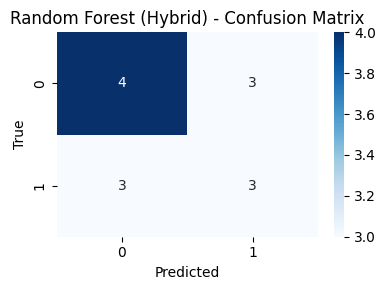

In [ ]:
rf_hybrid = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

start = time.time()
rf_hybrid.fit(Xh_train_scaled, yh_train)
end = time.time()

yh_pred_rf = rf_hybrid.predict(Xh_test_scaled)
yh_proba_rf = rf_hybrid.predict_proba(Xh_test_scaled)[:, 1]

acc_rf = accuracy_score(yh_test, yh_pred_rf)
prec_rf = precision_score(yh_test, yh_pred_rf)
rec_rf = recall_score(yh_test, yh_pred_rf)
f1_rf = f1_score(yh_test, yh_pred_rf)
auc_rf = roc_auc_score(yh_test, yh_proba_rf)

print("🌲 Random Forest (Hybrid) Results:")
print(f"✅ Accuracy:  {acc_rf:.3f}")
print(f"✅ Precision: {prec_rf:.3f}")
print(f"✅ Recall:    {rec_rf:.3f}")
print(f"✅ F1-score:  {f1_rf:.3f}")
print(f"✅ ROC-AUC:   {auc_rf:.3f}")
print(f"⏱️ Train Time: {end - start:.2f}s")

print("\nClassification Report:\n", classification_report(yh_test, yh_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(yh_test, yh_pred_rf))

# Visualize Confusion Matrix
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(yh_test, yh_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest (Hybrid) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

🔹 Handcrafted feature contribution: 0.106
🔹 WavLM embedding contribution: 0.894
✅ Total = 1.000


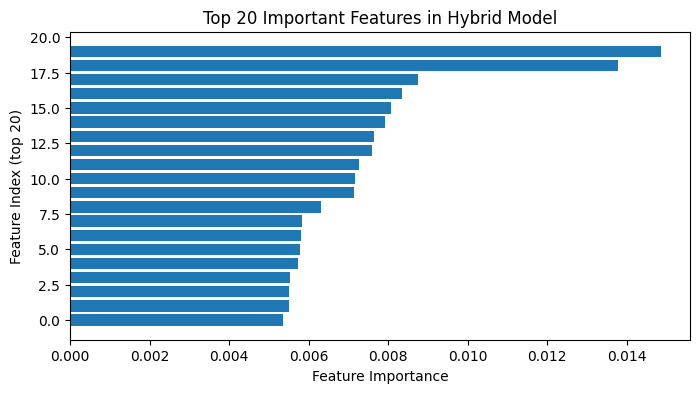

In [ ]:

# Get feature importances
importances = rf_hybrid.feature_importances_

# Split back into handcrafted vs embedding parts
n_handcrafted = X_handcrafted.shape[1]
handcrafted_importance = np.sum(importances[:n_handcrafted])
embedding_importance = np.sum(importances[n_handcrafted:])

print(f"🔹 Handcrafted feature contribution: {handcrafted_importance:.3f}")
print(f"🔹 WavLM embedding contribution: {embedding_importance:.3f}")
print(f"✅ Total = {handcrafted_importance + embedding_importance:.3f}")

# Optional — visualize top 20
sorted_idx = np.argsort(importances)[-20:]
plt.figure(figsize=(8, 4))
plt.barh(range(20), importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Index (top 20)")
plt.title("Top 20 Important Features in Hybrid Model")
plt.show()

In [ ]:
clf_hand = RandomForestClassifier(random_state=42)
clf_hand.fit(X_handcrafted, y_handcrafted)
print("Handcrafted-only Accuracy:", clf_hand.score(X_handcrafted, y_handcrafted))

clf_emb = RandomForestClassifier(random_state=42)
clf_emb.fit(X_wavlm, y_hybrid)
print("Embedding-only Accuracy:", clf_emb.score(X_wavlm, y_hybrid))

print("Hybrid Accuracy:", rf_hybrid.score(X_hybrid, y_hybrid))


Handcrafted-only Accuracy: 1.0
Embedding-only Accuracy: 1.0
Hybrid Accuracy: 0.49382716049382713


In [ ]:
print("X_handcrafted:", X_handcrafted.shape)
print("X_wavlm:", X_wavlm.shape)
print("X_hybrid:", X_hybrid.shape)
print("Scaler mean shape:", scaler_hybrid.mean_.shape)


X_handcrafted: (81, 81)
X_wavlm: (81, 768)
X_hybrid: (81, 849)
Scaler mean shape: (849,)


In [ ]:
explainer_rf = shap.TreeExplainer(rf_hybrid)
shap_values_rf = explainer_rf.shap_values(Xh_test_scaled)

In [ ]:
print(type(shap_values_rf))
if isinstance(shap_values_rf, list):
    print("list of", len(shap_values_rf), "arrays")
    print("shapes:", [a.shape for a in shap_values_rf])
else:
    print("array shape:", np.array(shap_values_rf).shape)


<class 'numpy.ndarray'>
array shape: (13, 849, 2)


In [ ]:
if shap_values_rf.ndim == 3 and shap_values_rf.shape[2] == 2:
    shap_values_rf = shap_values_rf[:, :, 1]   # keep only class 1 SHAP values

# Confirm new shape
print("After fix:", shap_values_rf.shape)

After fix: (13, 849)


In [ ]:
if len(hybrid_feature_names) < 852:
    hybrid_feature_names = [f"WavLM_{i}" for i in range(768)] + \
                           [f"Handcrafted_{i}" for i in range(84)]
    print(f"✅ Regenerated hybrid_feature_names ({len(hybrid_feature_names)})")

# Select SHAP values for class 1 (PD)
if shap_values_rf.ndim == 3 and shap_values_rf.shape[2] == 2:
    shap_values_rf = shap_values_rf[:, :, 1]  # Keep only PD class
    print("✅ Using class 1 SHAP values")

# Confirm shapes
print("Final SHAP shape:", shap_values_rf.shape)
print("Feature name count:", len(hybrid_feature_names))

# Compute mean absolute SHAP values
mean_abs_shap = np.mean(np.abs(shap_values_rf), axis=0)

# Top-5 influential features
top5_idx = np.argsort(mean_abs_shap)[-5:][::-1]
top5_features = [hybrid_feature_names[i] for i in top5_idx]
top5_values = mean_abs_shap[top5_idx]

Final SHAP shape: (13, 849)
Feature name count: 852



🏆 Top Influential Handcrafted and WavLM Features (Hybrid RF Model):


,Rank,Feature,Mean |SHAP Value|
0,1,LAR9_LAR_vars,0.01037
1,2,MFCC9_MFCC_vars,0.00859
2,3,LPC1_LPC_means,0.00817
3,4,MFCC10_MFCC_vars,0.00614
4,5,WavLM_360,0.00520


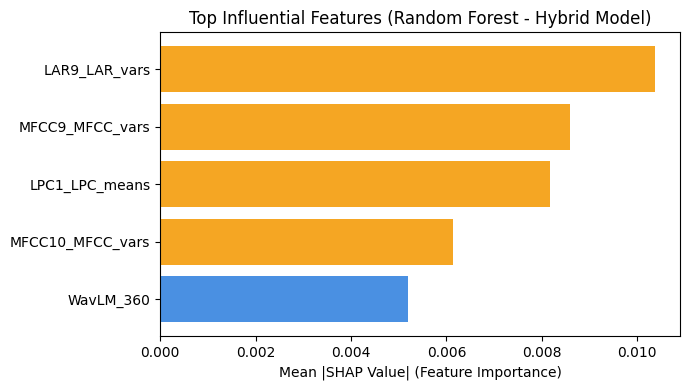

In [ ]:
# Keep only features that are actually hybrid (WavLM or handcrafted)
filtered_features = []
filtered_values = []

for f, v in zip(top5_features, top5_values):
    if f in hybrid_feature_names:
        filtered_features.append(f)
        filtered_values.append(v)

# Optional: take top 5 only
top_filtered_features = filtered_features[:5]
top_filtered_values = filtered_values[:5]

# Create DataFrame
top_df = pd.DataFrame({
    "Rank": range(1, len(top_filtered_features)+1),
    "Feature": top_filtered_features,
    "Mean |SHAP Value|": top_filtered_values
})

print("\n🏆 Top Influential Handcrafted and WavLM Features (Hybrid RF Model):")
display(top_df.round(5))

# Bar Plot
plt.figure(figsize=(7,4))
colors = ['#4A90E2' if 'WavLM' in f else '#F5A623' for f in top_df["Feature"]]
plt.barh(top_df["Feature"], top_df["Mean |SHAP Value|"], color=colors)
plt.xlabel("Mean |SHAP Value| (Feature Importance)")
plt.title("Top Influential Features (Random Forest - Hybrid Model)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# Reduce embeddings from 768 → 50 dims
pca = PCA(n_components=56, random_state=42)
X_wavlm_reduced = pca.fit_transform(X_wavlm)

# Combine with handcrafted
X_hybrid = np.concatenate([X_handcrafted, X_wavlm_reduced], axis=1)
print("Reduced hybrid shape:", X_hybrid.shape)


Reduced hybrid shape: (81, 137)


In [ ]:
X_hybrid_pca = np.concatenate([X_handcrafted, X_wavlm_reduced], axis=1)
y_hybrid = y_handcrafted

print("✅ Final hybrid feature shape:", X_hybrid_pca.shape)

✅ Final hybrid feature shape: (81, 137)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_hybrid_pca, y_hybrid, test_size=0.2, stratify=y_hybrid, random_state=42
)

In [ ]:
scaler_hybrid_pca = StandardScaler()
X_train_scaled = scaler_hybrid_pca.fit_transform(X_train)
X_test_scaled = scaler_hybrid_pca.transform(X_test)

# -------------------------------
# 🔹 Step 6: Train Random Forest
# -------------------------------
clf_hybrid_pca = RandomForestClassifier(
    n_estimators=300, max_depth=10, random_state=42
)
clf_hybrid_pca.fit(X_train_scaled, y_train)

# -------------------------------
# 🔹 Step 7: Evaluate
# -------------------------------
y_pred = clf_hybrid_pca.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Hybrid PCA Model Accuracy: {acc*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -------------------------------
# 🔹 Step 8: Feature contribution check (optional)
# -------------------------------
importances = clf_hybrid_pca.feature_importances_
n_handcrafted = X_handcrafted.shape[1]
print(f"\n🔹 Handcrafted contribution: {np.sum(importances[:n_handcrafted]):.3f}")
print(f"🔹 WavLM (reduced) contribution: {np.sum(importances[n_handcrafted:]):.3f}")



✅ Hybrid PCA Model Accuracy: 58.82%

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.67      0.63         9
           1       0.57      0.50      0.53         8

    accuracy                           0.59        17
   macro avg       0.59      0.58      0.58        17
weighted avg       0.59      0.59      0.59        17


Confusion Matrix:
 [[6 3]
 [4 4]]

🔹 Handcrafted contribution: 0.682
🔹 WavLM (reduced) contribution: 0.318


In [ ]:
explainer_hybrid_pca = shap.TreeExplainer(clf_hybrid_pca)

# Compute SHAP values for scaled test set
shap_values_hybrid_pca = explainer_hybrid_pca.shap_values(X_test_scaled)

# -------------------------------
# 2️⃣ Inspect shape and structure
# -------------------------------
if isinstance(shap_values_hybrid_pca, list):
    print("✅ SHAP for multiple classes detected.")
    print("Class count:", len(shap_values_hybrid_pca))
    print("Class 0 shape:", np.array(shap_values_hybrid_pca[0]).shape)
    print("Class 1 shape:", np.array(shap_values_hybrid_pca[1]).shape)
else:
    print("✅ Single-class SHAP output shape:", shap_values_hybrid_pca.shape)

✅ Single-class SHAP output shape: (17, 137, 2)


✅ Using SHAP array shape: (17, 137)
✅ X_test_scaled shape: (17, 137)


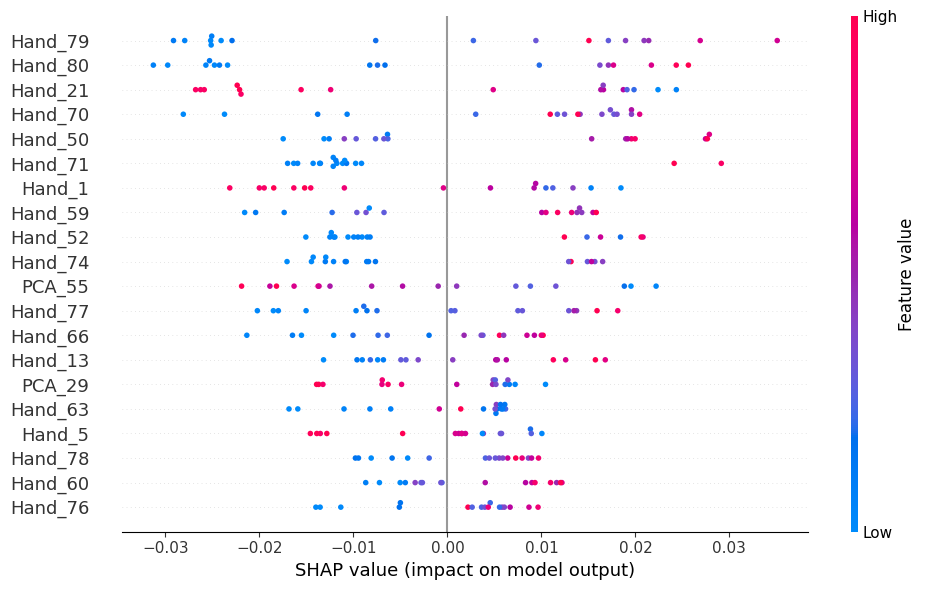

In [ ]:
# Extract SHAP values for PD class (index 1)
shap_to_plot = shap_values_hybrid_pca[:, :, 1]  # (17, 131)

print("✅ Using SHAP array shape:", shap_to_plot.shape)
print("✅ X_test_scaled shape:", X_test_scaled.shape)

# Redefine feature names just to be safe
n_handcrafted = X_handcrafted.shape[1]
feature_names = [f"Hand_{i+1}" for i in range(n_handcrafted)] + \
                [f"PCA_{i+1}" for i in range(X_wavlm_reduced.shape[1])]
feature_names = feature_names[:X_test_scaled.shape[1]]

# ✅ SHAP summary plot for PD class
shap.summary_plot(
    shap_to_plot,
    X_test_scaled,
    feature_names=feature_names,
    plot_size=(10,6),
    show=True
)


✅ Using SHAP array shape: (17, 137)
✅ X_test_scaled shape: (17, 137)

🔹 Handcrafted SHAP Contribution: 0.373
🔸 WavLM (PCA) SHAP Contribution: 0.138
✅ Total = 0.511


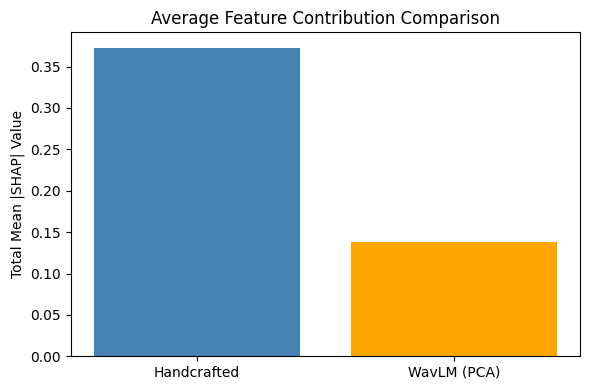

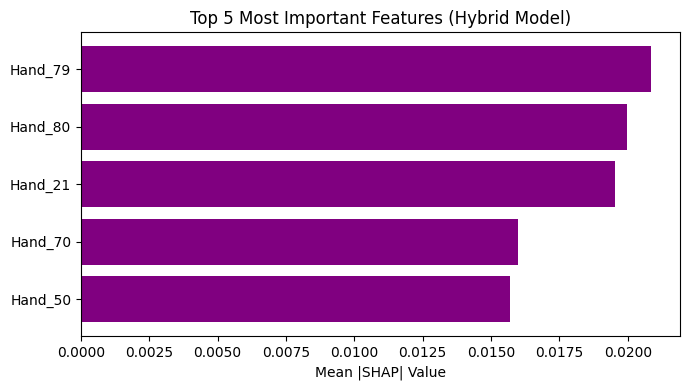

In [ ]:
shap_to_plot = shap_values_hybrid_pca[:, :, 1]  # (samples, features)
print("✅ Using SHAP array shape:", shap_to_plot.shape)
print("✅ X_test_scaled shape:", X_test_scaled.shape)

# --- Define feature names ---
n_handcrafted = X_handcrafted.shape[1]
feature_names = [f"Hand_{i+1}" for i in range(n_handcrafted)] + \
                [f"PCA_{i+1}" for i in range(X_wavlm_reduced.shape[1])]
feature_names = feature_names[:X_test_scaled.shape[1]]

# --- Mean absolute SHAP values for feature importance ---
mean_abs_shap = np.mean(np.abs(shap_to_plot), axis=0)

# --- Split handcrafted vs embedding (PCA) contributions ---
handcrafted_contrib = np.sum(mean_abs_shap[:n_handcrafted])
embedding_contrib = np.sum(mean_abs_shap[n_handcrafted:])
total = handcrafted_contrib + embedding_contrib

print(f"\n🔹 Handcrafted SHAP Contribution: {handcrafted_contrib:.3f}")
print(f"🔸 WavLM (PCA) SHAP Contribution: {embedding_contrib:.3f}")
print(f"✅ Total = {total:.3f}")

# --- Compare contributions visually ---
plt.figure(figsize=(6,4))
plt.bar(
    ["Handcrafted", "WavLM (PCA)"],
    [handcrafted_contrib, embedding_contrib],
    color=["steelblue", "orange"]
)
plt.ylabel("Total Mean |SHAP| Value")
plt.title("Average Feature Contribution Comparison")
plt.tight_layout()
plt.show()

# --- Top 5 most important features ---
top_idx = np.argsort(mean_abs_shap)[-5:]
plt.figure(figsize=(7,4))
plt.barh(np.array(feature_names)[top_idx], mean_abs_shap[top_idx], color='purple')
plt.xlabel("Mean |SHAP| Value")
plt.title("Top 5 Most Important Features (Hybrid Model)")
plt.tight_layout()
plt.show()

In [ ]:
from datetime import datetime

model_path = f"/content/drive/MyDrive/Major Project/hybrid_rf_{datetime.now().strftime('%Y%m%d_%H%M')}.joblib"
scaler_path = f"/content/drive/MyDrive/Major Project/hybrid_scaler.joblib"

# ✅ Save model and scaler
joblib.dump(clf_hybrid_pca, model_path)
joblib.dump(scaler_hybrid_pca, scaler_path)

print("✅ Hybrid PCA model saved at:", model_path)
print("✅ Scaler (hybrid PCA) saved at:", scaler_path)


✅ Hybrid PCA model saved at: /content/drive/MyDrive/Major Project/hybrid_rf_20251106_2034.joblib
✅ Scaler (hybrid PCA) saved at: /content/drive/MyDrive/Major Project/hybrid_scaler.joblib


In [ ]:
joblib.dump(pca, "/content/drive/MyDrive/Major Project/hybrid_pca_55.joblib")
print("✅ PCA saved")


✅ PCA saved
